In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import numpy as np
import math
from shutil import copy
import imutils

In [2]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

path = "../image/"

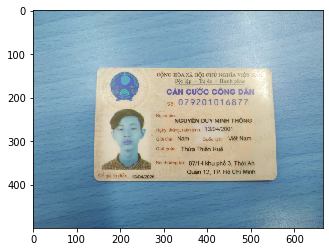

In [3]:
img = cv2.imread(path + 'cccd/NDMT_CCCD_Error.jpg')
ratio = img.shape[0] / 500.0
orig = img.copy()
img_scale = imutils.resize(img, height = 500)
show_image(img_scale)

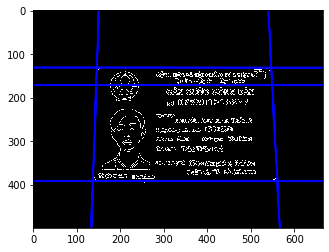

In [4]:
gray = cv2.cvtColor(img_scale, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(img_scale, (3, 3), 3)

dst = cv2.Canny(gray_blur, 50, 100, None, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
    
lines = cv2.HoughLines(dst, 1, np.pi / 180, 140, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        pt1_ls = list(pt1)
        pt2_ls = list(pt2)

        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
#cv2_imshow(out)
# cv2.imshow(cdst)
show_image(cdst)

In [5]:
pts = []
for i in range(lines.shape[0]):
    (rho1, theta1) = lines[i,0]
    m1 = -1/np.tan(theta1)
    c1 = rho1 / np.sin(theta1)
    for j in range(i+1,lines.shape[0]):
        (rho2, theta2) = lines[j,0]
        m2 = -1 / np.tan(theta2)
        c2 = rho2 / np.sin(theta2)
        if np.abs(m1 - m2) <= 1e-8:
            continue
        x = (c2 - c1) / (m1 - m2)
        y = m1*x + c1
        if 0 <= x < cdst.shape[1] and 0 <= y < cdst.shape[0]:
            pts.append((int(x), int(y)))

In [6]:
pts_corner = []
sorted_pts_x_axis = sorted(pts, key=lambda tup: tup[0])
sorted_pts_y_axis = sorted(pts, key=lambda tup: tup[1])

x_thres = (sorted_pts_x_axis[0][0] + sorted_pts_x_axis[-1][0]) / 2
y_thres = (sorted_pts_y_axis[0][1] + sorted_pts_y_axis[-1][1]) / 2

right = []
left = []

for i in range(len(pts)):
    if pts[i][0] <= x_thres:
        right.append(pts[i])
    else:
        left.append(pts[i]) 

In [7]:
centre_pt = (x_thres, y_thres)

def distance(pt1, pt2):
    pt1_ls = list(pt1)
    pt2_ls = list(pt2)

    return math.sqrt( (pt1[0]-pt2[0])**2 + (pt1[1]-pt2[1])**2 )

In [8]:
right_up = []
right_down = []
for i in range(len(right)):
    if right[i][1] <= y_thres:
        right_up.append(right[i])
    else:
        right_down.append(right[i]) 

thresh = -1
for i in range(len(right_up)):
    dist = distance(right_up[i], centre_pt)
    if dist > thresh:
        thresh = dist
        right_up_corner = right_up[i]
pts_corner.append(right_up_corner)

thresh = -1
for i in range(len(right_down)):
    dist = distance(right_down[i], centre_pt)
    if dist > thresh:
        thresh = dist
        right_down_corner = right_down[i]
pts_corner.append(right_down_corner)

In [9]:
left_up = []
left_down = []
for i in range(len(left)):
    if left[i][1] <= y_thres:
        left_up.append(left[i])
    else:
        left_down.append(left[i])

thresh = -1
for i in range(len(left_down)):
    dist = distance(left_down[i], centre_pt)
    if dist > thresh:
        thresh = dist
        left_down_corner = left_down[i]
pts_corner.append(left_down_corner)

thresh = -1
for i in range(len(left_up)):
    dist = distance(left_up[i], centre_pt)
    if dist > thresh:
        thresh = dist
        left_up_corner = left_up[i]
pts_corner.append(left_up_corner)

In [10]:
pts_np = np.array(pts_corner)
pts_use = pts_np[:,None] # We need to convert to a 3D numpy array with a singleton 2nd dimension
hull = cv2.convexHull(pts_use)

print(hull)

[[[561 392]]

 [[137 392]]

 [[146 132]]

 [[547 132]]]


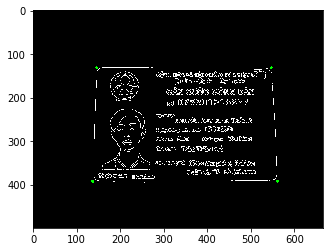

In [11]:
out2 = np.dstack([dst, dst, dst])
for pt in hull[:,0]:
    cv2.circle(out2, tuple(pt), 2, (0, 255, 0), 2)

show_image(out2)

In [12]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [13]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
                  [0, 0],
                  [maxWidth - 1, 0],
                  [maxWidth - 1, maxHeight - 1],
                  [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

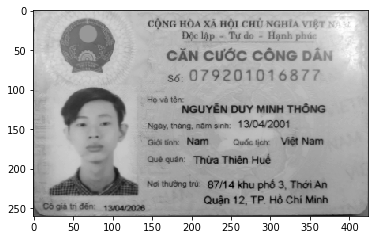

In [14]:
corner_arr = np.asarray(pts_corner, dtype = "float32")
warped = four_point_transform(img_scale, corner_arr)
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
show_image(warped)

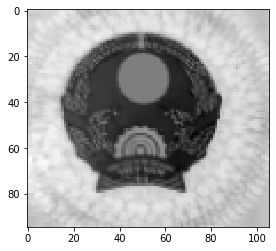

In [15]:
bin_img = warped

ratio_y = 3.1/8.4
ratio_x1 = 0.25/5.4
ratio_x2 = 1.6/5.4


national_symbol = bin_img[:int(bin_img.shape[0]*ratio_y),
                          int(bin_img.shape[1]*ratio_x1):int(bin_img.shape[1]*ratio_x2)
                          ]

show_image(national_symbol)

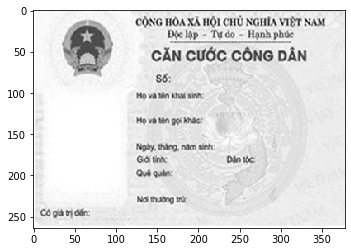

(264, 378)


In [16]:
format_standard = cv2.imread(path + 'template_checking/standard_format_CCCd.jpg', cv2.IMREAD_GRAYSCALE)
show_image(format_standard)
print(format_standard.shape)

(array([1]), array([14]))
1


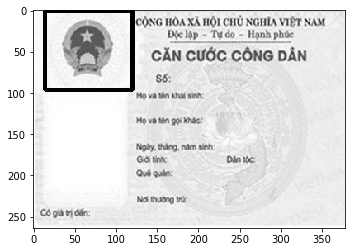

In [17]:
from matplotlib import pyplot as plt

w, h = national_symbol.shape[::-1]
res = cv2.matchTemplate(format_standard,national_symbol,cv2.TM_CCOEFF_NORMED)
# result = cv2.matchTemplate(gray_img, template, cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= 0.8)
print(loc)
print(len(loc[0]))
for pt in zip(*loc[::-1]):
    cv2.rectangle(format_standard, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 3)
show_image(format_standard)